In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from utility import create_graphs2D, create_graphs1D

In [3]:
ITERATIONS = 50
observed_x_bins = 60
observed_y_bins = 60
unfolded_x_bins = 30
unfolded_y_bins = 30

In [4]:
#rng generator from numpy
rng = np.random.default_rng()
#create fake data
# x_1 = rng.normal(0.3, 0.1, 30000)
# y_1 = rng.normal(0.75, 0.1, 30000)

# x_2 = rng.normal(0.72, 0.16, 45000)
# y_2 = rng.normal(0.44, 0.16, 45000)

# x_3 = rng.normal(0.55, 0.08, 10000)
# y_3 = rng.normal(0.65, 0.08, 10000)

x_uniform = rng.uniform(3, 7, 200000)
y_uniform = rng.uniform(-1, 1, 200000)
#combine into 2
# x_true_unfiltered = np.hstack((x_1, x_2, x_3, x_uniform))
# y_true_unfiltered = np.hstack((y_1, y_2, y_3, y_uniform))
x_true_unfiltered = x_uniform
y_true_unfiltered = y_uniform
#remove any values outside possible range
cond1 = (x_true_unfiltered > 3) & (x_true_unfiltered < 7)
cond2 = (y_true_unfiltered > -1) & (y_true_unfiltered < 1)

x_true_full = x_true_unfiltered[cond1&cond2]
y_true_full = y_true_unfiltered[cond1&cond2]
#smear the data
x_resolution_offset = rng.normal(0, 0.4, len(x_true_full))
y_resolution_offset = rng.normal(0, 0.1, len(y_true_full))
x_recon_unfiltered = x_true_full + x_resolution_offset
y_recon_unfiltered = y_true_full + y_resolution_offset
#assume that the true data can only be found in the range (0, 1)
cond3 = (x_recon_unfiltered> 3) & (x_recon_unfiltered < 7)
cond4 = (y_recon_unfiltered> -1) & (y_recon_unfiltered < 1)

#recon data with acceptance lost
x_recon = x_recon_unfiltered[cond3&cond4]
y_recon = y_recon_unfiltered[cond3&cond4]
#this true data is really only partial, use true_full for normalizing A matrix
x_true =  x_true_full[cond3&cond4] 
y_true =  y_true_full[cond3&cond4]

In [5]:
#weighting
def make_weights(x, y):
    return ((x - 3) / 4) + ((y + 1) / 2)
weights = make_weights(x_true, y_true)
print(weights)

[1.11163746 1.65335573 1.12910808 ... 1.10667344 0.96014898 1.64383423]


In [ ]:
#bin true and recon data
recon_binned = np.histogram2d(x_recon, y_recon, bins=(observed_x_bins,observed_y_bins), weights=weights)[0]
#compute A Matrix
A = np.histogramdd((x_recon, x_true, y_recon, y_true), bins=(observed_x_bins, unfolded_x_bins, observed_y_bins, unfolded_y_bins), weights=weights)[0]
# Normalize data, it must be the full set of true data, not trimmed down at all
true_binned_full = np.histogram2d(x_true_full, y_true_full, bins=(unfolded_x_bins,unfolded_y_bins), weights=make_weights(x_true_full, y_true_full))[0]
for i in range(len(A)):
    for j in range(len(true_binned_full)):
        A[i][j] /= true_binned_full[j] + 1e-12
#alpha for acceptance error
alpha = np.sum(np.sum(A, axis=2), axis=0)
print(alpha.shape)
print(A.dtype)

(30, 30)
float64


In [7]:
flat_recon_bins = recon_binned.flatten()
flat_A = A.transpose(0, 2, 1, 3).reshape(observed_x_bins * observed_y_bins, unfolded_x_bins * unfolded_y_bins)
flat_alpha = alpha.flatten()
print(flat_alpha.shape)

(900,)


In [8]:
#Implementation of the R-L algorithm
unfolded = np.array([len(x_true_full) / (unfolded_x_bins * unfolded_y_bins)] * (unfolded_x_bins * unfolded_y_bins)) #starting with uniform dist
for _ in range(ITERATIONS):
    d_k = np.matmul(flat_A, unfolded)
    ratio = flat_recon_bins / (d_k + 1e-12)  # avoid division by zero
    unfolded = unfolded * (flat_A.T @ ratio) / (flat_alpha + 1e-12)
#reshape back to 2D
final_unfolded = unfolded.reshape(unfolded_x_bins, unfolded_y_bins)

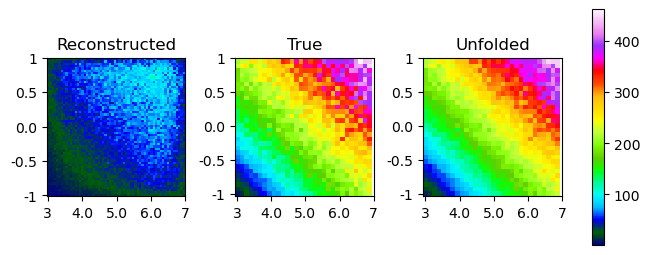

In [9]:
names = ['Reconstructed', 'True', 'Unfolded']
ticks = [[[3, 7], [-1, 1]], [[3, 7], [-1, 1]], [[3, 7], [-1, 1]]]
create_graphs2D([recon_binned.T, true_binned_full.T, final_unfolded.T], names, ticks, cmap='gist_ncar')

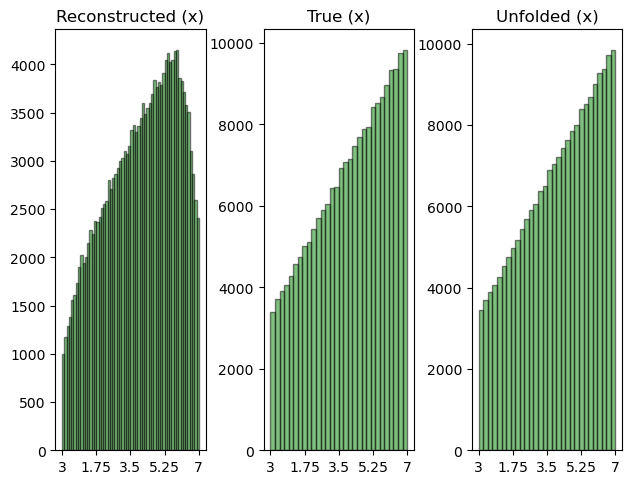

In [10]:
create_graphs1D([np.sum(recon_binned, axis=1), np.sum(true_binned_full, axis=1), np.sum(final_unfolded, axis=1)], ['Reconstructed (x)', 'True (x)', 'Unfolded (x)'], [[3, 7], [3, 7], [3, 7]], color = 'green')

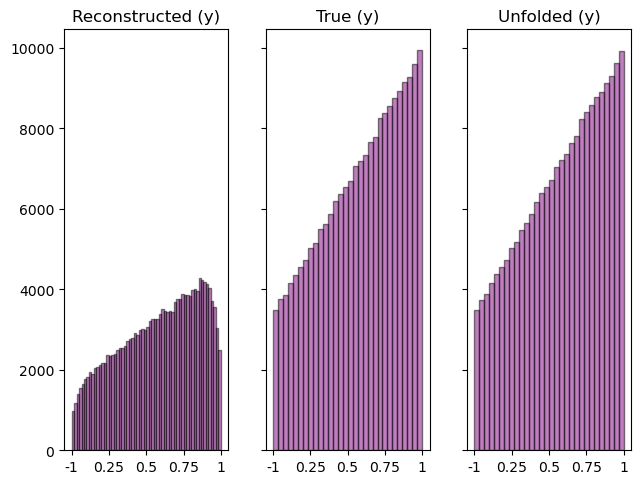

In [11]:
create_graphs1D([np.sum(recon_binned, axis=0), np.sum(true_binned_full, axis=0), np.sum(final_unfolded, axis=0)], ['Reconstructed (y)', 'True (y)', 'Unfolded (y)'], [[-1, 1], [-1, 1], [-1, 1]], color = 'purple', sharey = True)